In [2]:
import os
import openslide
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
import cv2
import staintools
import torch.nn as nn

In [3]:
carpeta_base = './GDCdata/'

# StainGAN

In [4]:
# Comprobamos si existe la carpeta Normalizadas, sino crearla
carpeta_normalizadas = os.path.join(carpeta_base, "Normalizadas")
os.makedirs(carpeta_normalizadas, exist_ok=True)

# Leer todas las imágenes .svs y guardarlas en un array
carpetas = []
archivos_final = []
imagenes_svs = []
imagenes_np = []
for carpeta, subcarpetas, archivos in os.walk(carpeta_base):
    for archivo in archivos:
        archivo_save = archivo.replace('.','-',1).split('.')[0]
        archivos_final.append(archivo_save)
        if archivo.endswith('.svs'):
            ruta_imagen = os.path.join(carpeta, archivo)
            imagenes_svs.append(ruta_imagen)
            carpetas.append(carpeta)
            slide = openslide.OpenSlide(ruta_imagen)
            nivel = 1  # Cambia esto si necesitas otro nivel de detalle
            dimensiones = slide.level_dimensions[nivel]
            imagen_np = np.array(slide.read_region((0, 0), level=nivel, size=dimensiones))[:, :, :3]

            # Guardar la imagen en la lista
            imagenes_np.append(imagen_np)


# AdaptiveAvgPool2d

In [5]:
# Lista para almacenar imágenes en formato tensor
imagenes_tensors = []

# Cargar imágenes con OpenSlide y convertirlas en tensores
for ruta in imagenes_svs:
    slide = openslide.OpenSlide(ruta)
    w, h = slide.level_dimensions[0]  # Tamaño en nivel 0 (máxima resolución)

    # Leer toda la imagen en nivel 0
    region = slide.read_region((0, 0), 0, (w, h)).convert("RGB")

    # Convertir a array de NumPy (formato PyTorch: C x H x W)
    imagen_np = np.array(region).transpose(2, 0, 1)  # De H x W x C → C x H x W
    imagen_tensor = torch.tensor(imagen_np, dtype=torch.float32) / 255.0  # Normalizar [0,1]

    # Agregar dimensión batch
    imagen_tensor = imagen_tensor.unsqueeze(0)  # (1, C, H, W)
    imagenes_tensors.append(imagen_tensor)

# Encontrar la mínima altura y anchura
min_alto = min(img.shape[2] for img in imagenes_tensors)  # Dimensión H
min_ancho = min(img.shape[3] for img in imagenes_tensors)  # Dimensión W

# Crear la capa de Adaptive Pooling para redimensionar al tamaño mínimo
adaptive_pool = nn.AdaptiveAvgPool2d((min_alto, min_ancho))

# Aplicar Adaptive Pooling a todas las imágenes
imagenes_redimensionadas = [adaptive_pool(img) for img in imagenes_tensors]

# Convertir de nuevo a NumPy y OpenCV (para visualizar o guardar)
imagenes_np_finales = [img.squeeze(0).permute(1, 2, 0).numpy() * 255 for img in imagenes_redimensionadas]

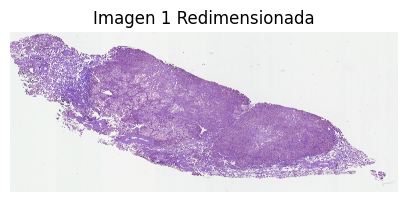

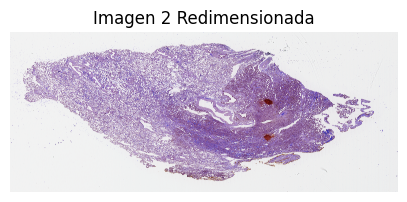

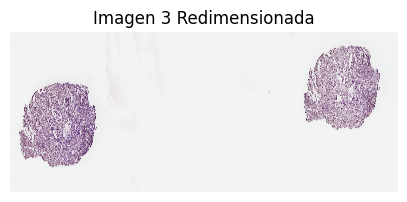

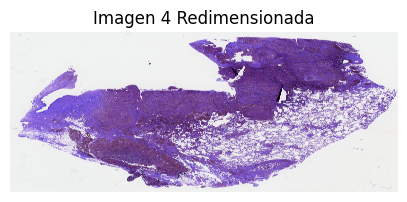

In [9]:
# Convertir a formato OpenCV BGR para visualización en Matplotlib
imagenes_np_finales = [cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR) for img in imagenes_np_finales]

# Mostrar imágenes redimensionadas
for i, img in enumerate(imagenes_np_finales):
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(imagenes_np_finales[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Imagen {i+1} Redimensionada")
    plt.axis("off")  # Ocultar ejes
    plt.show()

In [10]:
# Calcular el promedio cromático global
promedio_global = np.zeros_like(imagenes_np_finales[0], dtype=np.float32)
for imagen in imagenes_np_finales:
    promedio_global += imagen / len(imagenes_np_finales)

promedio_global = np.uint8(promedio_global)  # Convertir a uint8

# Crear y ajustar el normalizador con la referencia global
normalizador = staintools.ReinhardColorNormalizer()
# normalizador = staintools.ReinhardNormalizer()
normalizador.fit(promedio_global)

In [ ]:
imagenes_normalizadas = []
ruta_imagenes_normalizadas = []
for i, imagen in enumerate(imagenes_np_finales):
    imagen_normalizada = normalizador.transform(imagen)
    imagenes_normalizadas.append(imagen_normalizada)

    # Obtener nombre original sin extensión
    nombre_original = os.path.splitext(os.path.basename(imagenes_svs[i]))[0]
    nombre_archivo_normalizado = f"{nombre_original}_normalizada.png"

    # Definir ruta de guardado
    ruta_guardado = os.path.join(carpeta_normalizadas, nombre_archivo_normalizado)
    ruta_imagenes_normalizadas.append(ruta_guardado)

    # Guardar imagen normalizada
    imagen_pil = Image.fromarray(imagen_normalizada)
    imagen_pil.save(ruta_guardado)

    print(f"Imagen normalizada guardada en: {ruta_guardado}")

Imagen normalizada guardada en: ./GDCdata/Normalizadas/TCGA-55-8091-01Z-00-DX1.0996c58a-6e93-4092-8cb8-014d548fe60c_normalizada.png


In [ ]:
thumbnail_size = (300, 300)
plt.figure(figsize=(15, 10))
for i, ruta in enumerate(imagenes_svs):
    slide = openslide.OpenSlide(ruta)
    thumbnail = slide.get_thumbnail(thumbnail_size)  # Crear miniatura

    imagen_np = np.array(thumbnail)  # Convertir a NumPy array

    # Agregar subplot para cada imagen
    plt.subplot(1, len(imagenes_svs), i + 1)
    plt.imshow(imagen_np)
    plt.axis("off")  # Ocultar ejes
    plt.title(f"Imagen {i+1}")  # Título

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
Image.MAX_IMAGE_PIXELS = None # Aumentamos el límite de píxeles permitidos

# Iterar sobre las imágenes PNG
for i, ruta in enumerate(imagenes_np_finales):
    if not os.path.exists(ruta):
        print(f"Archivo no encontrado: {ruta}")
        continue
    
    imagen = Image.open(ruta)  # Abrir imagen con PIL
    imagen_np = np.array(imagen)  # Convertir a NumPy array

    # Agregar subplot para visualizar
    plt.subplot(1, len(ruta_imagenes_normalizadas), i + 1)
    plt.imshow(imagen_np)
    plt.axis("off")
    plt.title(f"Imagen {i+1}")

# Mostrar imágenes
plt.tight_layout()
plt.show()